## tidymodels to sklearn

Sklearn implementation of this tidymodels example:

In [1]:
import pandas as pd

cells = pd.read_csv("cells.csv")

In [2]:
from sklearn.model_selection import train_test_split

features = cells.drop('class', axis=1)
outcome = cells['class']

X_train, X_test, y_train, y_test = train_test_split(
    features, 
    outcome, 
    test_size=0.25, 
    random_state=0,
    stratify=outcome
)

In [3]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector


tree_preprocess = make_column_transformer(
    (FunctionTransformer(), features.columns[features.dtypes != 'object'])
)

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

tree_pipeline = make_pipeline(
    tree_preprocess,
    DecisionTreeClassifier()
)

In [5]:
# may need to use DecisionTreeClassifier.cost_complexity_pruning_path to generate recommendations
param_grid = {
    'decisiontreeclassifier__max_depth': [1, 4, 8, 11, 15],
    'decisiontreeclassifier__ccp_alpha': [0.0000000001, 0.0000000178, 0.00000316, 0.000562, 0.1] 
}

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

tree_tuner = GridSearchCV(
    tree_pipeline, param_grid, cv=5, 
    scoring={
        'roc_auc': make_scorer(roc_auc_score, needs_proba=True),
        'accuray': make_scorer(accuracy_score)
    },
    refit='roc_auc'
)

In [16]:
tree_tuner.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('functiontransformer',
                                                                         FunctionTransformer(),
                                                                         Index(['angle_ch_1', 'area_ch_1', 'avg_inten_ch_1', 'avg_inten_ch_2',
       'avg_inten_ch_3', 'avg_inten_ch_4', 'convex_hull_area_ratio_ch_1',
       'convex_hull_perim_ratio_ch_1', 'diff_inten_density_ch_1',
       'diff_inten_density_c...
       'var_inten_ch_3', 'var_inten_ch_4', 'width_ch_1'],
      dtype='object'))])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             param_grid={'decisiontreeclassifier__ccp_alpha': [1e-10, 1.78e-08,
                                                               3.16e-06,
                                        

In [17]:
tree_tuner.best_params_

{'decisiontreeclassifier__ccp_alpha': 3.16e-06,
 'decisiontreeclassifier__max_depth': 4}

In [23]:
# how do you use multiple metrics?
pd.DataFrame(tree_tuner.cv_results_) \
    .sort_values('mean_test_accuray', ascending=False) \
    [[
        'param_decisiontreeclassifier__ccp_alpha', 
        'param_decisiontreeclassifier__max_depth',
        'mean_test_accuray', 'mean_test_roc_auc'
    ]] \
    .head(5)

,param_decisiontreeclassifier__ccp_alpha,param_decisiontreeclassifier__max_depth,mean_test_accuray,mean_test_roc_auc
11,3.16e-06,4,0.797220,0.859174
16,0.000562,4,0.793920,0.857550
6,1.78e-08,4,0.793920,0.856505
1,1e-10,4,0.793920,0.854492
7,1.78e-08,8,0.793277,0.781984


In [25]:
# see refit='roc_auc'
best_tree = tree_tuner.best_estimator_.named_steps['decisiontreeclassifier']

In [26]:
ct = tree_tuner.best_estimator_.named_steps['columntransformer']

In [35]:
feature_importances = pd.DataFrame({'name': ct.transformers_[0][2]}) \
    .assign(importance = best_tree.feature_importances_) \
    .sort_values('importance', ascending=False)

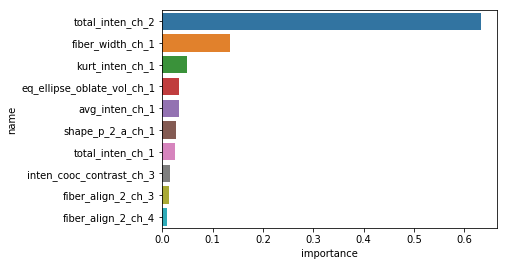

In [37]:
import seaborn as sns
sns.barplot(x='importance', y='name', data=feature_importances.head(10))

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, average_precision_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, plot_roc_curve

In [43]:
make_scorer(accuracy_score)(best_tree, X_test, y_test)

ValueError: could not convert string to float: 'Train'